In [ ]:
using Distributions
using LinearAlgebra
using ProgressMeter
using OrdinaryDiffEq

In [ ]:
using Pkg;
Pkg.activate("..")
using EnKF

In [ ]:
using Plots
gr(framestyle = :box)
# clibrary(:colorbrewer)
# pyplot()

We are interested in simulating the Duffing oscillator with forcing
                $$\frac{d^2 x}{dt^2} = x - x^3 - \gamma \dot{x}   + d cos(\omega t)$$
with $\gamma = 0.1, d = 0.1$ and $\omega = 1.4$

Reference: http://physics.ucsc.edu/~peter/115/duffing.pdf

First, let us solve the dynamical equation using DifferentialEquations.jl with $x₀ = [1.0, -1.0]$ on  $[0.0, 50.0]$ with a RK4 method

We also define an `integrator` that will can propagate our solution from time t to t + Δt 

In [33]:
function duffing(du,u,p,t)
 du[1] = u[2]
 du[2] = u[1] - u[1]^3 -γ*u[2] + d*cos(ω*t)
end

γ = 0.1
d = 0.1
ω = 1.4

u0 = [1.0; -1.0]
tspan = (0.0,50.0)

Δt = 1e-2
T = tspan[1]:Δt:tspan[end]

prob = ODEProblem(duffing, u0, tspan)
sol = solve(prob, RK4(), adaptive = false, dt = Δt)

integrator = init(prob, RK4(), adaptive =false, dt = Δt, save_everystep=false)

t: 0.0
u: 2-element Vector{Float64}:
  1.0
 -1.0

Plot solution

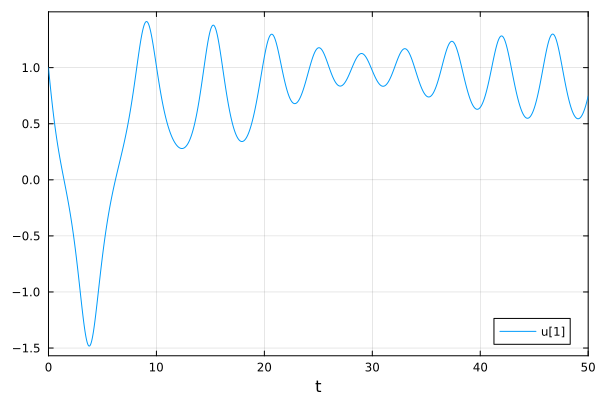

In [34]:
plot(sol, vars = (1))

## Tools for the ensemble Kalman filter

The ensemble Kalman filter known under the sobriquet EnKF is a Monte-Carlo view of the Kalman filter suited for large and nonlinear systems introduced by Evensen, et al.(1999)

In [35]:
function (::PropagationFunction)(t::Float64, ENS::EnsembleState{N,TS}) where {N,TS}
  for (i, s) in enumerate(ENS.S)

    set_t!(integrator, deepcopy(t))
    set_u!(integrator, deepcopy(s))
    #         for j=1:10
    step!(integrator)
    #         end
    ENS.S[i] = deepcopy(integrator.u)

  end

  return ENS
end

In [36]:
fprop = PropagationFunction()

PropagationFunction()

Define measurement function m

In [37]:
function (::MeasurementFunction)(t::Float64, s::TS) where TS
  return [s[2]]
end

function (::MeasurementFunction)(t::Float64) # error function
  return reshape([0.0, 1.0], (1, 2))
end

In [38]:
# reshape([0.0, 1.0], (1, 2))

In [39]:
m = MeasurementFunction()

MeasurementFunction()

Define  real measurement function z

In [40]:
function (::RealMeasurementFunction)(t::Float64, ENS::EnsembleState{N,TZ}) where {N,TZ}
  let s = sol(t)
    fill!(ENS, [deepcopy(s[2])])
  end
  return ENS
end

z = RealMeasurementFunction()


RealMeasurementFunction()

Define covariance inflation

In [41]:
# A = MultiAdditiveInflation(2, 1.05, MvNormal(zeros(2), 2.0*I))
A = IdentityInflation()

IdentityInflation()

Define noise covariance

In [42]:
ϵ = AdditiveInflation(MvNormal(zeros(1), 1.0*I))

AdditiveInflation{1}(IsoNormal(
dim: 1
μ: [0.0]
Σ: [1.0;;]
)
)

In [43]:
N = 50
NZ = 1
isinflated = false
isfiltered = false
isaugmented = false

false

In [44]:
x₀ = [0.5, -0.5]
ens = initialize(N, MvNormal(x₀, 2.0 * I))


EnsembleState{50, Vector{Float64}}([[0.18750818800133073, -0.6343629190500448], [-3.1150230419866753, -0.04078831634213853], [0.7973145357415203, -2.0461834427856123], [-0.05280907735244955, 2.2757965535762428], [0.5677942938502534, 1.4415261761709792], [1.869913107122455, -4.235601674742666], [-0.5786951822060122, 0.26378094836159016], [-0.6741629790560291, 2.7082115479076827], [0.26683732591633996, 1.295203681324199], [0.9627657842408849, 2.711432567142223]  …  [-0.6535771302116113, -0.19378629718380574], [0.15546252127168697, -1.7317341704401028], [0.4619635566677072, 1.2568846488486292], [-0.3083418253515877, -2.128710351866059], [0.6239115727985746, -0.9446523569853086], [-1.3063073943369712, -2.2705388090776344], [-2.3635969061978037, 0.8231126113010971], [-0.10186381425540625, 1.1141573315201034], [1.9516082566307713, -0.5788055815832942], [-0.6194653123628842, -1.8107258586561035]])

In [45]:
ens.S[1]

2-element Vector{Float64}:
  0.18750818800133073
 -0.6343629190500448

In [46]:
estimation_state = [deepcopy(ens.S)]

true_state = [deepcopy(x₀)]
covs = []

Any[]

In [47]:
g = FilteringFunction()

FilteringFunction()

In [49]:
enkf = ENKF(N, NZ, fprop, A, g, m, z, ϵ; isinflated, isfiltered, isaugmented)

ENKF{50, 1}(PropagationFunction(), IdentityInflation(), FilteringFunction(), MeasurementFunction(), RealMeasurementFunction(), AdditiveInflation{1}(IsoNormal(
dim: 1
μ: [0.0]
Σ: [1.0;;]
)
), true, false, false, false)

### Ensemble Kalman filter estimation

In [ ]:
Δt = 1e-2
Tsub = 0.0:Δt:50.0-Δt

for (n, t) in enumerate(Tsub)
  global ens
  t, ens, cov = enkf(t, Δt, ens)

  push!(estimation_state, deepcopy(ens.S))
  push!(covs, deepcopy(cov))
end

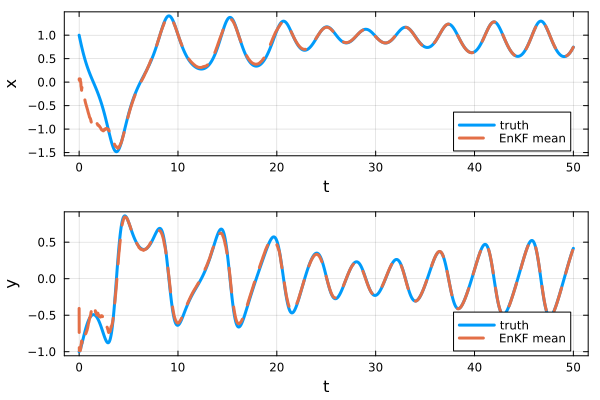

In [51]:
s =  hcat(sol(T).u...)
ŝ =  hcat(mean.(estimation_state)...)

plt = plot(layout = (2, 1), legend = :bottomright)
plot!(plt[1], T, s[1,1:end], linewidth = 3, label = "truth")
plot!(plt[1], Tsub, ŝ[1,1:end-1], linewidth = 3, markersize = 2, label = "EnKF mean", xlabel = "t", ylabel = "x", linestyle =:dash)

plot!(plt[2], T, s[2,1:end], linewidth = 3, label = "truth")
plot!(plt[2], Tsub, ŝ[2,1:end-1], linewidth = 3, markersize = 2, label = "EnKF mean", xlabel = "t", ylabel = "y", linestyle =:dash)

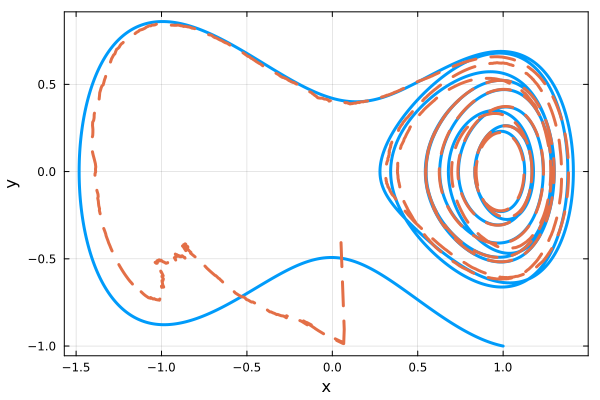

In [52]:
plot(s[1,:], s[2,:], linewidth = 3, label = "truth", legend = true)
plot!(ŝ[1,1:end-1], ŝ[2,1:end-1], linewidth = 3, label = "EnKF mean", xlabel = "x", 
    ylabel = "y", linestyle = :dash, legend = false)#:bottomleft)

Plot diagonal components of the *a posteriori* covariance

┌ Warning: z:\GitHub\jl-pkgs\EnKF.jl\src\initial.jl no longer exists, deleted all methods
└ @ Revise C:\Users\hydro\.julia\packages\Revise\tTIBp\src\packagedef.jl:720
┌ Warning: z:\GitHub\jl-pkgs\EnKF.jl\src\stochasticEnKF.jl no longer exists, deleted all methods
└ @ Revise C:\Users\hydro\.julia\packages\Revise\tTIBp\src\packagedef.jl:720


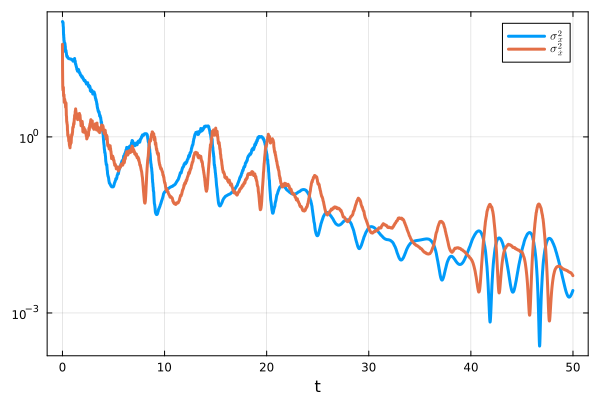

In [55]:
using LaTeXStrings

plot(Tsub, map(covs) do P  
        P[1,1]+ eps() end, yscale = :log10, linewidth = 3, label = L"\sigma^2_{x}")
plot!(Tsub, map(covs) do P
        P[2,2]+ eps() end, yscale = :log10, linewidth = 3, xlabel = "t", label = L"\sigma^2_{\dot{x}}")